# Build your own non-personalized recommender

## Import

In [2]:
!pip install -q kaggle
!pip install scikit-surprise

In [3]:
from collections import defaultdict
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle

from surprise import Reader, AlgoBase, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate, KFold

# Setup

In [4]:
def setup_kaggle():
  from google.colab import files
  uploaded = files.upload()
  !chmod 600 kaggle.json
  %mkdir -p /root/.kaggle/
  %mv kaggle.json /root/.kaggle/

setup_kaggle()

Saving kaggle.json to kaggle.json


In [5]:
kaggle.api.authenticate()

my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)

# Set plot styling
plt.style.use('ggplot')
sns.set(style="whitegrid")

## Download Book-Crossing dataset

In [ ]:
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip book-recommendation-dataset.zip

In [ ]:
books_df = pd.read_csv('Books.csv')
ratings_df = pd.read_csv('Ratings.csv')

print("\nBooks dataset:")
display(books_df.head())

print("\nRatings dataset:")
display(ratings_df.head())

<ipython-input-7-be602d8f39af>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv('Books.csv')



Books dataset:


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...



Ratings dataset:


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## EDA

### Basics

In [ ]:
print("Books DataFrame Info:")
books_df.info()

print("\nRatings DataFrame Info:")
ratings_df.info()

print("\nMissing values in Books DataFrame:")
print(books_df.isnull().sum())

print("\nMissing values in Ratings DataFrame:")
print(ratings_df.isnull().sum())

Books DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB

Ratings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  

In [9]:
print("Number of unique books:", len(books_df['ISBN'].unique()))
print("Number of unique ratings:", len(ratings_df['Book-Rating'].unique())) # 0-10

Number of unique books: 271360
Number of unique ratings: 11


In [10]:
mean = ratings_df['Book-Rating'].mean()
std = ratings_df['Book-Rating'].std()
print(f'The ratings mean is {round(mean, 2)} and std is {round(std, 4)}')

The ratings mean is 2.87 and std is 3.8542


### Distributions analysis

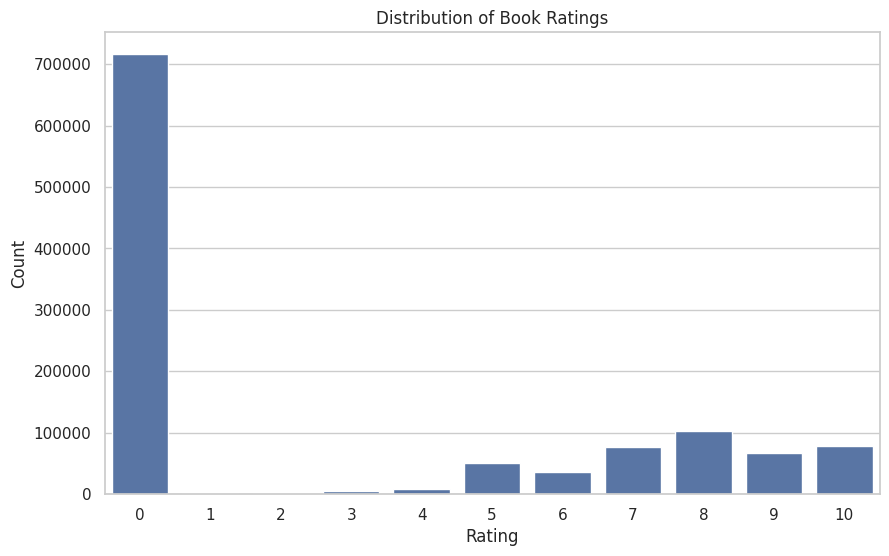


Percentage of implicit ratings (0): 62.28%
Percentage of explicit ratings (1-10): 37.72%


In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=ratings_df, x='Book-Rating')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Calculate percentage of implicit ratings (rating = 0)
implicit_count = (ratings_df['Book-Rating'] == 0).sum()
total_ratings = len(ratings_df)
print(f"\nPercentage of implicit ratings (0): {implicit_count/total_ratings*100:.2f}%")
print(f"Percentage of explicit ratings (1-10): {(1-implicit_count/total_ratings)*100:.2f}%")

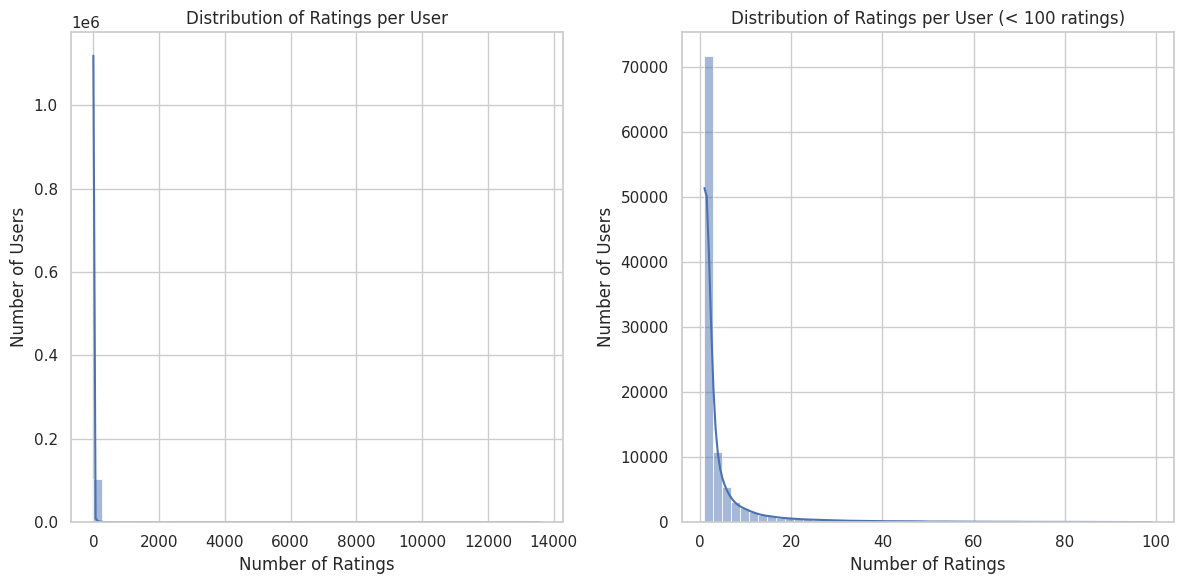


Average number of ratings per user: 10.92
Median number of ratings per user: 1.0
Maximum number of ratings by a user: 13602


In [12]:
# Analyze user activity (number of ratings per user)
user_activity = ratings_df['User-ID'].value_counts()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(user_activity, bins=50, kde=True)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
sns.histplot(user_activity[user_activity < 100], bins=50, kde=True)
plt.title('Distribution of Ratings per User (< 100 ratings)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

print(f"\nAverage number of ratings per user: {user_activity.mean():.2f}")
print(f"Median number of ratings per user: {user_activity.median()}")
print(f"Maximum number of ratings by a user: {user_activity.max()}")

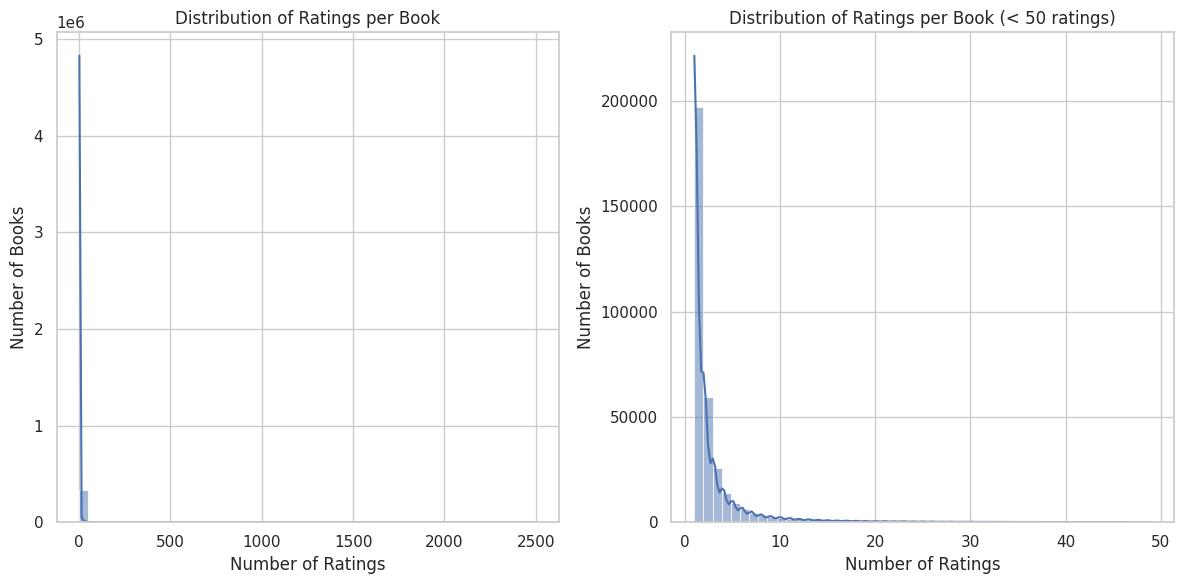


Average number of ratings per book: 3.38
Median number of ratings per book: 1.0
Maximum number of ratings for a book: 2502


In [13]:
# Analyze book popularity (number of ratings per book)
book_popularity = ratings_df['ISBN'].value_counts()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(book_popularity, bins=50, kde=True)
plt.title('Distribution of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')

plt.subplot(1, 2, 2)
sns.histplot(book_popularity[book_popularity < 50], bins=50, kde=True)
plt.title('Distribution of Ratings per Book (< 50 ratings)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
plt.tight_layout()
plt.show()

print(f"\nAverage number of ratings per book: {book_popularity.mean():.2f}")
print(f"Median number of ratings per book: {book_popularity.median()}")
print(f"Maximum number of ratings for a book: {book_popularity.max()}")

Both distributions of ratings per user and per book respect expected **Power Law distribution**.

### Top 10 most rated books

In [14]:
top_books = book_popularity.head(10).index.tolist()
top_books_titles = books_df[books_df['ISBN'].isin(top_books)][['ISBN', 'Book-Title', 'Book-Author']]
print("\nTop 10 most rated books:")
display(top_books_titles)


Top 10 most rated books:


,ISBN,Book-Title,Book-Author
26,0971880107,Wild Animus,Rich Shapero
118,0671027360,Angels &amp; Demons,Dan Brown
305,044023722X,A Painted House,John Grisham
356,0142001740,The Secret Life of Bees,Sue Monk Kidd
408,0316666343,The Lovely Bones: A Novel,Alice Sebold
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant
748,0385504209,The Da Vinci Code,Dan Brown
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
1922,067976402X,Snow Falling on Cedars,David Guterson


### User-item matrix

In [15]:
# Calculate the sparsity of the user-item matrix
n_users = ratings_df['User-ID'].nunique()
n_books = ratings_df['ISBN'].nunique()
density = len(ratings_df) / (n_users * n_books) * 100

print(f"Number of unique users: {n_users}")
print(f"Number of unique books: {n_books}")
print(f"Number of ratings: {len(ratings_df)}")
print(f"Matrix density: {density:.4f}%")
print(f"Matrix sparsity: {100-density:.4f}%")

Number of unique users: 105283
Number of unique books: 340556
Number of ratings: 1149780
Matrix density: 0.0032%
Matrix sparsity: 99.9968%


### Explicit & Implicit feedback

Explicit feedback dataset shape: (433671, 3)
Implicit feedback dataset shape: (1149780, 4)



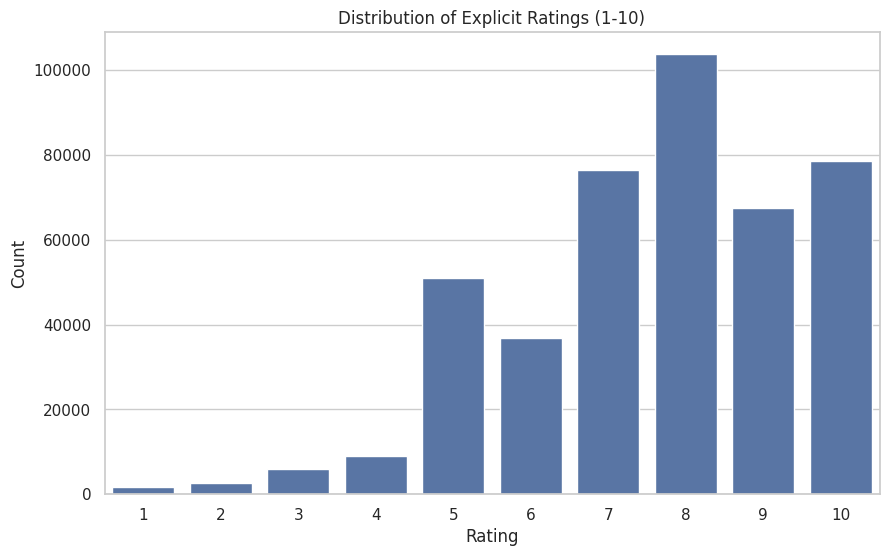


Average explicit rating: 7.60


In [16]:
# Create explicit feedback view (ratings > 0)
explicit_df = ratings_df[ratings_df['Book-Rating'] > 0].copy()
print(f"Explicit feedback dataset shape: {explicit_df.shape}")

# Create implicit feedback view (convert all ratings to 1 to indicate interaction)
implicit_df = ratings_df.copy()
implicit_df['Interaction'] = 1
print(f"Implicit feedback dataset shape: {implicit_df.shape}\n")

# Analyze the distribution of explicit ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=explicit_df, x='Book-Rating')
plt.title('Distribution of Explicit Ratings (1-10)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

print(f"\nAverage explicit rating: {explicit_df['Book-Rating'].mean():.2f}")

### Summary

In [17]:
print("Key Dataset Insights:")
print(f"- Total number of ratings: {len(ratings_df):,}")
print(f"- Number of unique users: {n_users:,}")
print(f"- Number of unique books: {n_books:,}")
print(f"- Matrix sparsity: {100-density:.4f}%")
print(f"- Percentage of implicit ratings (0): {implicit_count/total_ratings*100:.2f}%")
print(f"- Average explicit rating: {explicit_df['Book-Rating'].mean():.2f}")
print(f"- Most active user rated {user_activity.max()} books")
print(f"- Most popular book has {book_popularity.max()} ratings")

Key Dataset Insights:
- Total number of ratings: 1,149,780
- Number of unique users: 105,283
- Number of unique books: 340,556
- Matrix sparsity: 99.9968%
- Percentage of implicit ratings (0): 62.28%
- Average explicit rating: 7.60
- Most active user rated 13602 books
- Most popular book has 2502 ratings


## Test/Train Split

In [18]:
# Define reader for explicit feedback (ratings 1-10)
explicit_reader = Reader(rating_scale=(1, 10))
explicit_data = Dataset.load_from_df(explicit_df[['User-ID', 'ISBN', 'Book-Rating']], explicit_reader)

# Define reader for implicit feedback (all interactions = 1)
implicit_reader = Reader(rating_scale=(1, 1))
implicit_df_for_surprise = implicit_df[['User-ID', 'ISBN', 'Interaction']].rename(columns={'Interaction': 'Rating'})
implicit_data = Dataset.load_from_df(implicit_df_for_surprise[['User-ID', 'ISBN', 'Rating']], implicit_reader)

# Split data
explicit_trainset, explicit_testset = train_test_split(explicit_data, test_size=0.2, random_state=my_seed)
implicit_trainset, implicit_testset = train_test_split(implicit_data, test_size=0.2, random_state=my_seed)

## Recommenders

### Random

In [19]:
class MyRandomRecommender(AlgoBase):
    """
    Random recommender based on the normal distribution of ratings.
    """

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        """
        Predict a random rating from the normal distribution.
        Note: u and i are not used as this is non-personalized.
        """
        return np.random.normal(loc=self.train_mean, scale=self.train_std)

    def fit(self, trainset):
        """
        Train the algorithm on the trainset.
        """
        AlgoBase.fit(self, trainset)

        # Calculate mean and standard deviation of all ratings
        ratings = [r for (_, _, r) in self.trainset.all_ratings()]
        self.train_mean = np.mean(ratings)
        self.train_std = np.std(ratings)

        return self


random_RS = MyRandomRecommender()

### Popular

In [20]:
class MyPopularRecommender(AlgoBase):
    """
    Popularity-based recommender that predicts the average rating for each item.
    """

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        """
        Predict the average rating for item i.
        Note: u is not used as this is non-personalized.
        """
        # Convert internal item id to raw item id
        try:
            raw_iid = self.trainset.to_raw_iid(i)
        except ValueError:
            # If item not in training set, return global mean
            return self.trainset.global_mean

        if raw_iid in self.mean_rating_per_item_df.index:
            return self.mean_rating_per_item_df.loc[raw_iid]['rating']
        else:
            # For items not in training set, return global mean
            return self.trainset.global_mean

    def fit(self, trainset):
        """
        Train the algorithm on the trainset.
        """
        AlgoBase.fit(self, trainset)

        # Convert internal ids to raw ids for better readability
        ratings_list = [(self.trainset.to_raw_iid(i), r) for (_, i, r) in self.trainset.all_ratings()]

        # Create DataFrame of all ratings
        ratings_df = pd.DataFrame(ratings_list, columns=['item', 'rating'])

        # Calculate mean rating per item
        self.mean_rating_per_item_df = (ratings_df
            .groupby('item')
            .agg({'rating': 'mean'})
        )

        return self



popular_RS = MyPopularRecommender()

### Collaborative Filtering (SVD)

In [21]:
cf_RS = SVD(random_state=my_seed)

### Bayesian Average Popular Recommender

In [ ]:
class BayesianPopularityRecommender(AlgoBase):
    """
    Bayesian average popularity-based recommender that adjusts for item uncertainty.
    Items with few ratings are pulled toward the global mean.
    """

    def __init__(self, prior_weight=10):
        AlgoBase.__init__(self)
        self.prior_weight = prior_weight  # C parameter

    def estimate(self, u, i):
        """
        Predict the Bayesian average rating for item i.
        Note: u is not used as this is non-personalized.
        """
        # Handle unknown items
        try:
            # Try to convert internal item id to raw item id
            raw_iid = self.trainset.to_raw_iid(i)

            # Check if we have a Bayesian average for this item
            if raw_iid in self.bayesian_average_df.index:
                return self.bayesian_average_df.loc[raw_iid]['bayesian_average']
            else:
                # Item exists in training set but has no Bayesian average
                return self.trainset.global_mean

        except ValueError:
            # Item not in training set at all (unknown item)
            return self.trainset.global_mean

    def fit(self, trainset):
        """
        Train the algorithm on the trainset.
        """
        AlgoBase.fit(self, trainset)

        # Convert internal ids to raw ids for better readability
        ratings_list = [(self.trainset.to_raw_iid(i), r) for (_, i, r) in self.trainset.all_ratings()]

        ratings_df = pd.DataFrame(ratings_list, columns=['item', 'rating'])

        item_stats = ratings_df.groupby('item').agg({
            'rating': ['count', 'sum', 'mean']
        })

        # Flatten multi-level columns
        item_stats.columns = ['count', 'sum', 'mean']

        global_mean = ratings_df['rating'].mean()

        # Apply Bayesian average formula: (C * M + sum of ratings) / (C + number of ratings)
        item_stats['bayesian_average'] = (
            (self.prior_weight * global_mean + item_stats['sum']) /
            (self.prior_weight + item_stats['count'])
        )

        self.bayesian_average_df = item_stats

        return self

bayesian_popular_RS = BayesianPopularityRecommender()

## Evaluation

### Test RMSE

In [22]:
random_RS.fit(explicit_trainset);
predictions_random = random_RS.test(explicit_testset)
accuracy.rmse(predictions_random, verbose=True);

RMSE: 2.4995


In [23]:
popular_RS.fit(explicit_trainset);
predictions_popular = popular_RS.test(explicit_testset)
accuracy.rmse(predictions_popular, verbose=True);

RMSE: 1.9458


In [24]:
cf_RS.fit(explicit_trainset);
predictions_cf = cf_RS.test(explicit_testset)
accuracy.rmse(predictions_cf, verbose=True);

RMSE: 1.6392


In [55]:
bayesian_popular_RS.fit(explicit_trainset);
predictions_bp = bayesian_popular_RS.test(explicit_testset)
accuracy.rmse(predictions_bp, verbose=True);

RMSE: 1.8110


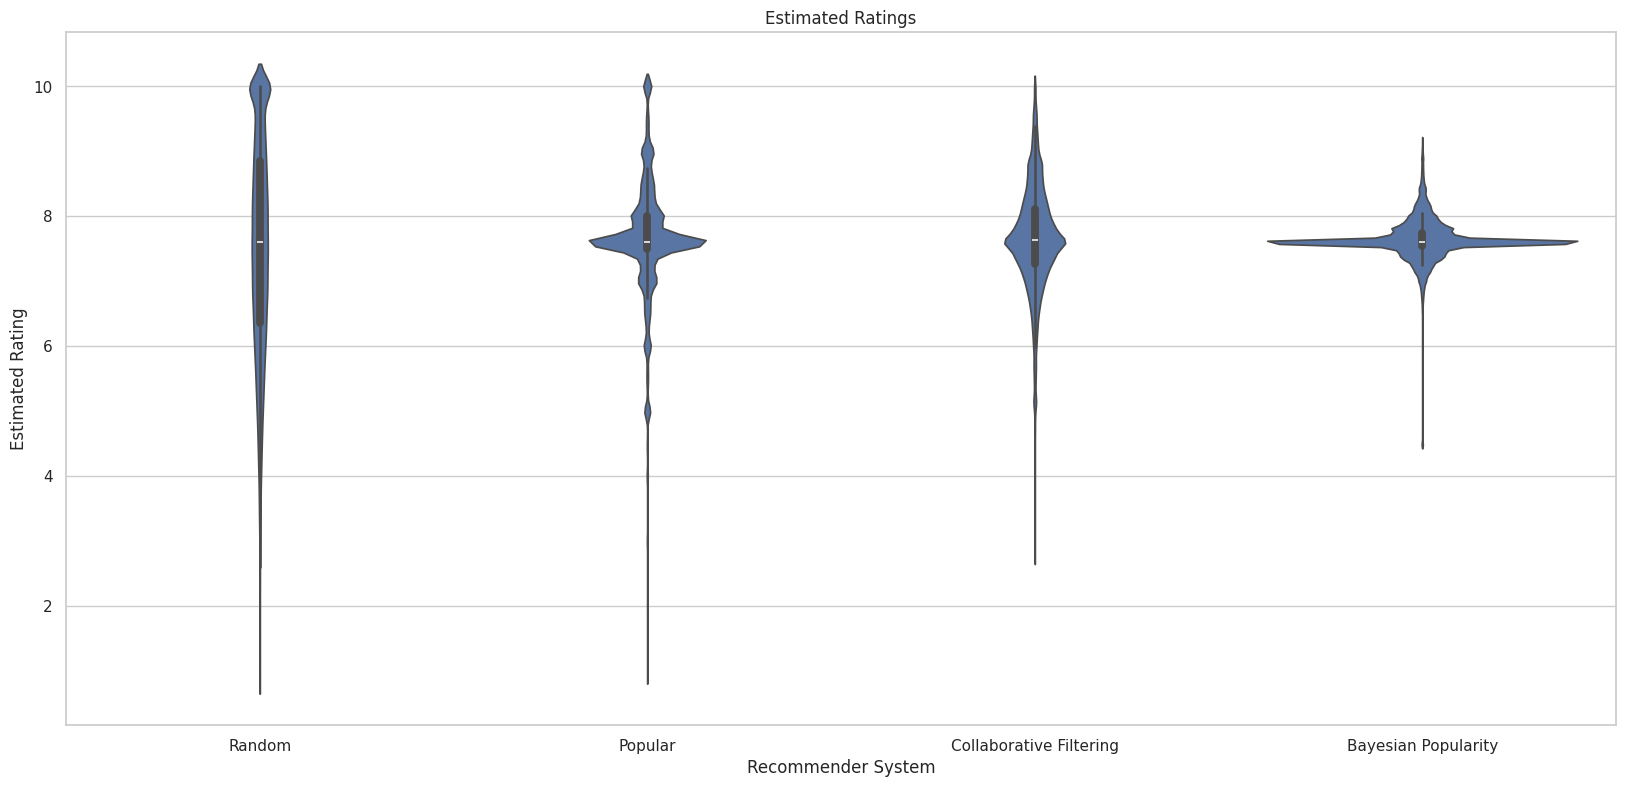

In [ ]:
def get_ratings_df(predictions):
    ratings = []
    for pred in predictions:
        ratings.append({'uid': pred.uid, 'iid': pred.iid, 'r_ui': pred.r_ui, 'est': pred.est, 'details': pred.details})
    return pd.DataFrame(ratings)

random_ratings_df = get_ratings_df(predictions_random)
popular_ratings_df = get_ratings_df(predictions_popular)
cf_ratings_df = get_ratings_df(predictions_cf)
bp_ratings_df = get_ratings_df(predictions_bp)

# Combine all ratings into a single dataframe for easier plotting
all_ratings = pd.concat([random_ratings_df.assign(RS='Random'),
                         popular_ratings_df.assign(RS='Popular'),
                         cf_ratings_df.assign(RS='Collaborative Filtering'),
                         bp_ratings_df.assign(RS='Bayesian Popularity')
                         ])


plt.figure(figsize=(20, 9))
sns.violinplot(x='RS', y='est', data=all_ratings)
plt.title('Estimated Ratings')
plt.xlabel('Recommender System')
plt.ylabel('Estimated Rating')
plt.show()


### Cross Validation - Explicit Feedback

In [26]:
metrics = ['RMSE', 'MAE']
n_folds = 5

In [ ]:
print("Evaluating recommenders on explicit feedback data...")

explicit_results = {}

# Random Recommender
print("\nEvaluating Random Recommender...")
start_time = time.time()
explicit_results['Random'] = cross_validate(random_RS, explicit_data,
                                           measures=metrics,
                                           cv=n_folds,
                                           verbose=True,
                                           return_train_measures=False)
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

# Popularity-based Recommender
print("\nEvaluating Popularity Recommender...")
start_time = time.time()
explicit_results['Popularity'] = cross_validate(popular_RS, explicit_data,
                                               measures=metrics,
                                               cv=n_folds,
                                               verbose=True,
                                               return_train_measures=False)
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

# Collaborative Filtering (SVD as baseline)
print("\nEvaluating Collaborative Filtering (SVD)...")
start_time = time.time()
explicit_results['SVD'] = cross_validate(cf_RS, explicit_data,
                                        measures=metrics,
                                        cv=n_folds,
                                        verbose=True,
                                        return_train_measures=False)
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

# Bayesian Average Popular Recommender
print("\nEvaluating Bayesian Average Popular Recommender...")
start_time = time.time()
explicit_results['Bayesian Popularity'] = cross_validate(bayesian_popular_RS, explicit_data,
                                                           measures=metrics,
                                                           cv=n_folds,
                                                           verbose=True,
                                                           return_train_measures=False)
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

Evaluating recommenders on explicit feedback data...

Evaluating Random Recommender...
Evaluating RMSE, MAE of algorithm MyRandomRecommender on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.5149  2.5072  2.5093  2.5109  2.5056  2.5096  0.0032  
MAE (testset)     2.0068  1.9972  2.0023  2.0041  2.0006  2.0022  0.0032  
Fit time          0.50    0.57    0.50    0.50    0.59    0.53    0.04    
Test time         0.43    0.80    0.54    0.50    0.73    0.60    0.14    
Evaluation completed in 19.58 seconds

Evaluating Popularity Recommender...
Evaluating RMSE, MAE of algorithm MyPopularRecommender on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9513  1.9338  1.9457  1.9506  1.9477  1.9458  0.0063  
MAE (testset)     1.5383  1.5235  1.5339  1.5346  1.5339  1.5328  0.0050  
Fit time          1.28    1.29    1.25    1.26    1.27    1.27    0.01    
Test time         2.5

In [ ]:
explicit_comparison = pd.DataFrame(columns=['RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std'])

for name, result in explicit_results.items():
    explicit_comparison.loc[name] = [
        result['test_rmse'].mean(),
        result['test_rmse'].std(),
        result['test_mae'].mean(),
        result['test_mae'].std()
    ]

explicit_comparison = explicit_comparison.sort_values('RMSE_mean')
print(explicit_comparison)

                     RMSE_mean  RMSE_std  MAE_mean   MAE_std
SVD                   1.642220  0.003760  1.267121  0.003174
Bayesian Popularity   1.813816  0.003658  1.456758  0.003537
Popularity            1.945828  0.006334  1.532832  0.004963
Random                2.509583  0.003216  2.002180  0.003242


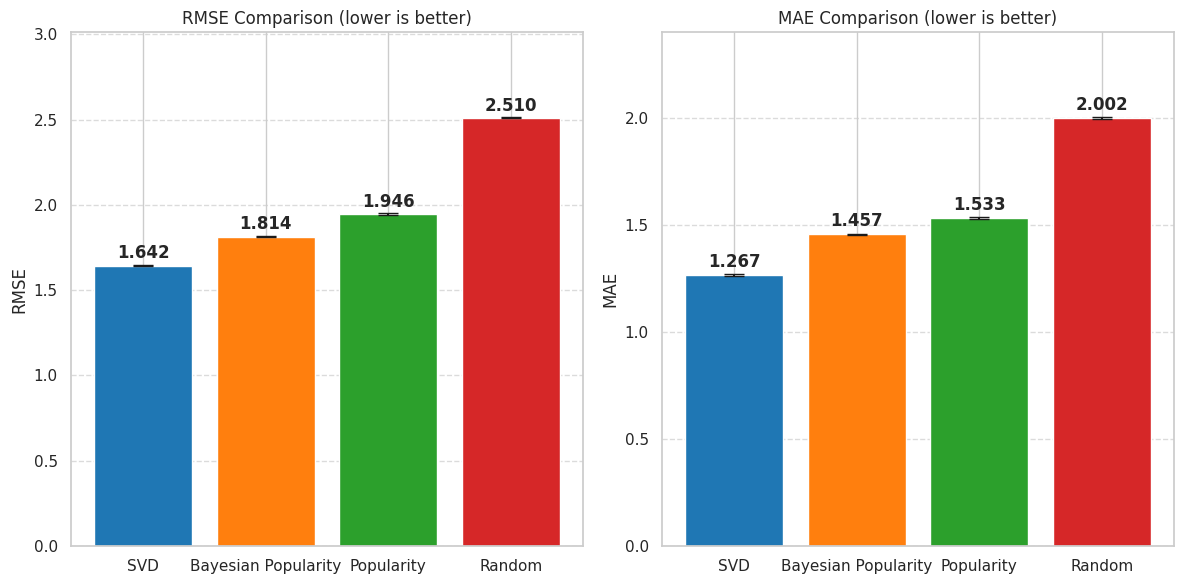

In [ ]:
# Comparing RMSE and MAE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = plt.bar(explicit_comparison.index, explicit_comparison['RMSE_mean'], yerr=explicit_comparison['RMSE_std'],
       capsize=7, color=colors)

for bar, value in zip(bars, explicit_comparison['RMSE_mean']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title('RMSE Comparison (lower is better)')
plt.ylabel('RMSE')
plt.ylim(0, explicit_comparison['RMSE_mean'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot MAE
plt.subplot(1, 2, 2)
bars = plt.bar(explicit_comparison.index, explicit_comparison['MAE_mean'], yerr=explicit_comparison['MAE_std'],
       capsize=7, color=colors)

# Add values on top of bars
for bar, value in zip(bars, explicit_comparison['MAE_mean']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title('MAE Comparison (lower is better)')
plt.ylabel('MAE')
plt.ylim(0, explicit_comparison['MAE_mean'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('explicit_feedback_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#### **Results**

The results of the cross validation align perfectly with theoretical expectations: CF with SVD far outperforms both Popular and, of course, Random as well. The substantial 34.4% improvement in RMSE from Random to SVD show the inherent potential of personalization. That said, this accuracy comes with computational costs, as SVD requires much more processing time (10.20s vs 1.51s for Popularity and 0.81s for Random).

Therefore, deciding which model to implement is not as straightforward as simply choosing the one with the best performance metric: for applications with limited compute or frequent cold-starts, a Popular recommender offers a good balance of performance and efficiency, while CF approaches should be deployed when performance is key above all else and sufficient user interaction data is available.

Regarding the Bayesian approach, it will take into a count not only the rating itself, but also the number of ratings for each item. Thus, it will "smooth out" extreme ratings on books with limited feedback, which translates to more stable recommendations that are less susceptible to statistical anomalies.

# Extra

## Stratified Per-User Evaluation

In [ ]:
def stratified_per_user_evaluate(algo, testset, measures=['rmse', 'mae']):
    """
    Evaluates recommender algorithms with metrics calculated per user.
    Each user contributes equally to the final metrics regardless of rating count.

    Parameters:
    -----------
    algo : AlgoBase
        Trained recommender algorithm
    testset : list
        List of (user, item, rating) tuples to test on
    measures : list
        List of metrics to compute

    Returns:
    --------
    dict
        Dictionary of metric results
    """
    predictions = algo.test(testset)

    # Group predictions by user
    user_predictions = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_predictions[uid].append((true_r, est))

    user_metrics = defaultdict(dict)

    for uid, user_preds in user_predictions.items():
        # Skip users with too few ratings for meaningful metrics
        if len(user_preds) < 2:
            continue

        true_ratings = np.array([true_r for true_r, _ in user_preds])
        estimated_ratings = np.array([est for _, est in user_preds])

        if 'rmse' in measures:
            user_metrics[uid]['rmse'] = np.sqrt(np.mean((true_ratings - estimated_ratings) ** 2))

        if 'mae' in measures:
            user_metrics[uid]['mae'] = np.mean(np.abs(true_ratings - estimated_ratings))

    # Average metrics across users
    results = {}
    for measure in measures:
        user_values = [metrics[measure] for uid, metrics in user_metrics.items()
                      if measure in metrics]
        if user_values:
            results[measure] = np.mean(user_values)
            results[f'{measure}_std'] = np.std(user_values)
            results[f'{measure}_users'] = len(user_values)
        else:
            results[measure] = float('nan')
            results[f'{measure}_std'] = float('nan')
            results[f'{measure}_users'] = 0

    return results

In [ ]:
def stratified_cross_validate(algo, data, measures=['rmse', 'mae'], cv=5, verbose=False, seed=42):
    """
    Perform cross-validation with per-user stratified metrics.

    Parameters:
    -----------
    algo : AlgoBase
        Recommender algorithm to evaluate
    data : Dataset
        Dataset to evaluate on
    measures : list
        List of metrics to compute
    cv : int
        Number of cross-validation folds
    verbose : bool
        Whether to print progress
    seed : int
        Random seed for reproducibility

    Returns:
    --------
    dict
        Dictionary of evaluation results
    """
    from surprise.model_selection import KFold

    kf = KFold(n_splits=cv, random_state=seed)

    # Metrics to track across folds
    all_results = defaultdict(list)

    for fold_i, (trainset, testset) in enumerate(kf.split(data)):
        if verbose:
            print(f"Fold {fold_i+1}/{cv}...")

        algo.fit(trainset)

        # Evaluate with stratified metrics
        fold_results = stratified_per_user_evaluate(
            algo, testset, measures=measures
        )

        # Store results
        for metric, value in fold_results.items():
            all_results[metric].append(value)

        if verbose:
            print(f"  Fold {fold_i+1} RMSE: {fold_results.get('rmse', 'N/A'):.4f}, MAE: {fold_results.get('mae', 'N/A'):.4f}")

    results = {}
    for metric in measures:
        results[f'{metric}_mean'] = np.mean(all_results[metric])
        results[f'{metric}_std'] = np.std(all_results[metric])

    return results

In [ ]:
# Initialize recommenders
random_RS = MyRandomRecommender()
popular_RS = MyPopularRecommender()
bayesian_RS = BayesianPopularityRecommender(prior_weight=10)
cf_RS = SVD(random_state=my_seed)

print("Running stratified evaluation on explicit feedback...")
explicit_results = {}

metrics = ['rmse', 'mae']

# Random Recommender
print("\nEvaluating Random Recommender...")
start_time = time.time()
explicit_results['Random'] = stratified_cross_validate(
    random_RS, explicit_data,
    measures=metrics, cv=5, verbose=True, seed=my_seed
)
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

# Popularity Recommender
print("\nEvaluating Popularity Recommender...")
start_time = time.time()
explicit_results['Popularity'] = stratified_cross_validate(
    popular_RS, explicit_data,
    measures=metrics, cv=5, verbose=True, seed=my_seed
)
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

# Bayesian Popularity Recommender
print("\nEvaluating Bayesian Popularity Recommender...")
start_time = time.time()
explicit_results['Bayesian'] = stratified_cross_validate(
    bayesian_RS, explicit_data,
    measures=metrics, cv=5, verbose=True, seed=my_seed
)
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

# Collaborative Filtering
print("\nEvaluating Collaborative Filtering (SVD)...")
start_time = time.time()
explicit_results['SVD'] = stratified_cross_validate(
    cf_RS, explicit_data,
    measures=metrics, cv=5, verbose=True, seed=my_seed
)
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

Running stratified evaluation on explicit feedback...

Evaluating Random Recommender...
Fold 1/5...
  Fold 1 RMSE: 2.3236, MAE: 2.0114
Fold 2/5...
  Fold 2 RMSE: 2.3175, MAE: 2.0045
Fold 3/5...
  Fold 3 RMSE: 2.3176, MAE: 2.0107
Fold 4/5...
  Fold 4 RMSE: 2.3457, MAE: 2.0314
Fold 5/5...
  Fold 5 RMSE: 2.3211, MAE: 2.0094
Evaluation completed in 19.30 seconds

Evaluating Popularity Recommender...
Fold 1/5...
  Fold 1 RMSE: 1.7886, MAE: 1.5519
Fold 2/5...
  Fold 2 RMSE: 1.7689, MAE: 1.5381
Fold 3/5...
  Fold 3 RMSE: 1.7656, MAE: 1.5346
Fold 4/5...
  Fold 4 RMSE: 1.7666, MAE: 1.5349
Fold 5/5...
  Fold 5 RMSE: 1.7761, MAE: 1.5438
Evaluation completed in 32.09 seconds

Evaluating Bayesian Popularity Recommender...
Fold 1/5...
  Fold 1 RMSE: 1.6742, MAE: 1.4759
Fold 2/5...
  Fold 2 RMSE: 1.6554, MAE: 1.4606
Fold 3/5...
  Fold 3 RMSE: 1.6520, MAE: 1.4592
Fold 4/5...
  Fold 4 RMSE: 1.6615, MAE: 1.4668
Fold 5/5...
  Fold 5 RMSE: 1.6614, MAE: 1.4668
Evaluation completed in 39.82 seconds

Evaluat


Stratified Per-User Evaluation Results:
                RMSE  RMSE_std       MAE   MAE_std
SVD         1.514624  0.007074  1.319734  0.005443
Bayesian    1.660900  0.007568  1.465851  0.005906
Popularity  1.773155  0.008556  1.540665  0.006519
Random      2.325101  0.010569  2.013491  0.009271



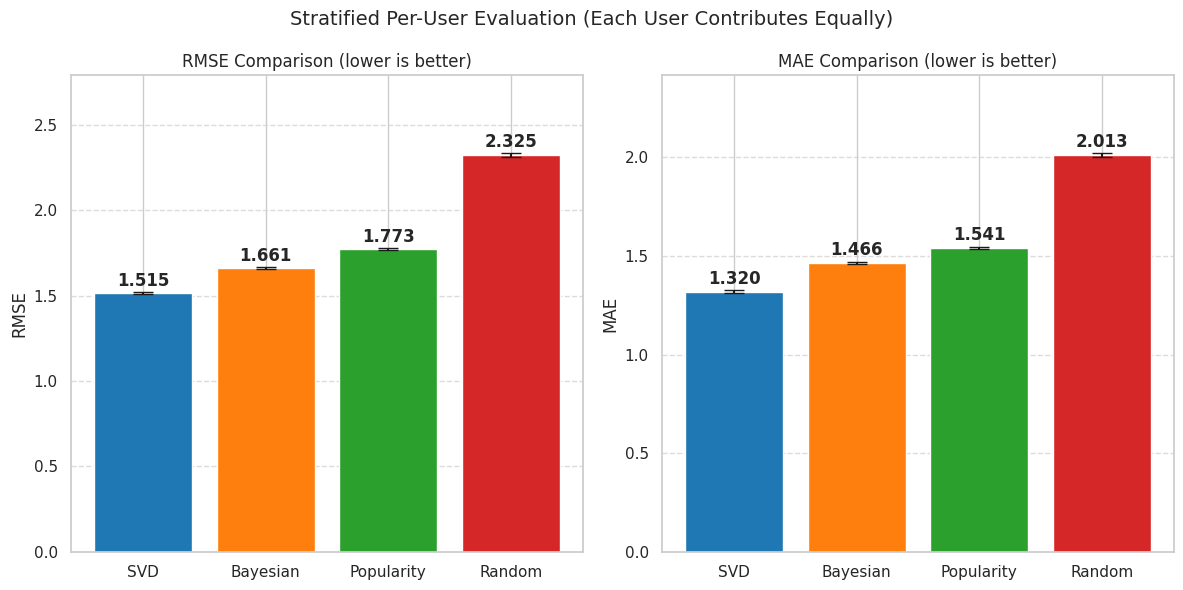

In [ ]:
comparison_df = pd.DataFrame({
    'RMSE': [results['rmse_mean'] for _, results in explicit_results.items()],
    'RMSE_std': [results['rmse_std'] for _, results in explicit_results.items()],
    'MAE': [results['mae_mean'] for _, results in explicit_results.items()],
    'MAE_std': [results['mae_std'] for _, results in explicit_results.items()]
}, index=explicit_results.keys())

comparison_df = comparison_df.sort_values('RMSE')

print("\nStratified Per-User Evaluation Results:")
print(comparison_df)
print()

# Create visualizations
plt.figure(figsize=(12, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
bars = plt.bar(comparison_df.index, comparison_df['RMSE'],
       yerr=comparison_df['RMSE_std'], capsize=7,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for bar, value in zip(bars, comparison_df['RMSE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title('RMSE Comparison (lower is better)')
plt.ylabel('RMSE')
plt.ylim(0, comparison_df['RMSE'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot MAE
plt.subplot(1, 2, 2)
bars = plt.bar(comparison_df.index, comparison_df['MAE'],
       yerr=comparison_df['MAE_std'], capsize=7,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for bar, value in zip(bars, comparison_df['MAE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title('MAE Comparison (lower is better)')
plt.ylabel('MAE')
plt.ylim(0, comparison_df['MAE'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Stratified Per-User Evaluation (Each User Contributes Equally)', fontsize=14)
plt.tight_layout()
plt.savefig('stratified_evaluation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### **Results**

The stratified results provide a more accurate picture of real-world performance by not letting active users overwhelm the metrics, providing stakeholders with a clearer picture of how each recommender would rank across the whole user base, including casual and new users who may have limited rating history.